# BASIC MODEL

## Classes

In [20]:
#import libraries
import numpy as np
import pandas as pd
import pylab as plt
import time
import glob, os, os.path
import osmnx as ox
import networkx as nx
import cv2
from functools import lru_cache

In [21]:
class Ambulances(object):
  """An ambulance class"""
  count = 0 
  ambs = []
  def __init__(self,verb=False):
    self.a_uid = self.count #unique id
    self.a_home = None #initial location
    self.a_dead = False #to check if it is out of the model
    self.a_state = 0 #code for state=> e.g 0:wait; 1:moving
    self.a_origin = None #start location
    self.a_destination = None #end location
    self.a_velocity = (0,1) #needs to be adjusted based on unit of model
    #to control uid and an aggregated list
    self.__class__.count += 1
    Ambulances.ambs.append(self)


In [22]:
class Pedestrians(object):
  """A pedestrian class"""
  count = 0
  peds = []
  def __init__(self,verb=False):
    self.p_uid = self.count
    self.p_age = 0
    self.p_gender = 0 #0:female;1:male
    self.p_home = None
    self.p_triage = 0 #0:no level; 1:green; 2:yellow; 3:red; 4:black
    self.p_state = 0
    self.p_origin = None
    self.p_destination = None
    self.p_velocity = (0,0.5)
    #to control uid and an aggregated list
    self.__class__.count +=1
    Pedestrians.peds.append(self)

In [23]:
class Hospitals(object):
  """A hospital class"""
  count = 0
  bldgs = []
  def __init__(self,verb=False):
    self.b_uid = self.count
    self.b_capacity = 0 #a number of max in-patients
    self.b_home = None #location of the building
    self.b_state = 0 #situation of behavior e.g. 0:available; 1:unavailable
    self.b_staff = 0 #number of doctors
    self.b_damage = 0 #level or flag of damage 0 is none
    self.b_inpatients = 0 #number of patients
    #to control uid and an aggregated list
    self.__class__.count +=1
    Hospitals.bldgs.append(self)

In [24]:
class Environment(object):
  def __init__(self,bbox,verb=False):
    #bbox is a dict of north,south,east,west lat,lon edges of target area
    self.e_bbox = {'north': bbox['north'], 'south': bbox['south'],
                     'east': bbox['east'], 'west': bbox['west']}
    self.e_network(self)

  @lru_cache(maxsize=16)
  def e_network(self,verb=False):
    # Obtain the roadmap data from OpenStreetMap by using OSMNX 
    self.e_G = ox.graph_from_bbox(self.e_bbox['north'], self.e_bbox['south'], 
                           self.e_bbox['east'], self.e_bbox['west'], 
                           network_type='drive')
  
  def e_project_network(self,verb=False):
    #Project network
    self.e_Gp = ox.project_graph(self.e_G)
  
  def e_get_nodes(self,verb=False):
    self.e_nodes, self.e_edges = ox.graph_to_gdfs(self.e_G)
    return self.e_nodes
  
  def e_get_edges(self,verb=False):
    self.e_nodes, self.e_edges = ox.graph_to_gdfs(self.e_G)
    return self.e_edges

  def e_plot(self,verb=False):
    #returning a fig and ax
    return ox.plot_graph(self.e_G,figsize=(16,8),bgcolor='w',node_color='k',
                         node_alpha=0.1,edge_color=(0,0,0,0.5),show=False,
                         close=False)

In [25]:
class Model(object):
  #Default parameters: Area (Kochi)
  arahama = {'north': 38.2271, 'south': 38.2077,
           'east': 140.9894, 'west': 140.9695}
  def __init__(self,bbox=arahama,hospitals=10,ambulances=3,
               population=50,verb=False):
    self.Env = Environment(bbox)
    self.nodes = self.Env.e_get_nodes()
    self.edges = self.Env.e_edges
    for i in range(hospitals):
      h = Hospitals()
      s = self.nodes.sample()
      h.home = (float(s['x']),
                float(s['y']))
    for i in range(ambulances):
      a = Ambulances()
      s = self.nodes.sample()
      a.home = (float(s['x']),
                float(s['y']))
    for i in range(population):
      p = Pedestrians()
      s = self.nodes.sample()
      p.home = (float(s['x']),
                float(s['y']))

  def go(self,sim_time=5,plot=False,video=False,verb=False):
    for t in range(sim_time):
      for i,a in enumerate(Ambulances.ambs):
        s = self.nodes.sample()
        a.home = (float(s['x']),
                float(s['y']))
      if plot:
        self.plot(id=t,save=True)
    if video:
      self.video()

  def plot(self,id=0,save=False,verb=False):
    #plot network
    fig,ax = self.Env.e_plot()
    #plot hospitals
    x = [h.home[0] for h in Hospitals.bldgs]
    y = [h.home[1] for h in Hospitals.bldgs]
    ax.scatter(x,y,c='r',marker='+')
    #plot ambulances
    x = [a.home[0] for a in Ambulances.ambs]
    y = [a.home[1] for a in Ambulances.ambs]
    ax.scatter(x,y,c='b',marker='s')
    #plot pedestrians
    x = [p.home[0] for p in Pedestrians.peds]
    y = [p.home[1] for p in Pedestrians.peds]
    ax.scatter(x,y,c='m',marker='.')
    if save:
      plt.savefig(f'./img/fig{id:04d}.png')
      plt.close()
      print(f'figure {id:04d} plotted')
  
  def video(self,image_folder='./img',
            video_name = './anim.avi',
            fps=1,verbose=False):
    images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name,cv2.VideoWriter_fourcc('M','J','P','G'), 
                            fps, (width,height))
    for image in images:
        if verbose:
            print(image)
        video.write(cv2.imread(os.path.join(image_folder, image)))
    cv2.destroyAllWindows()
    video.release()

## Parameters

For bounding box (bbox) of other areas:
[OSM](https://www.openstreetmap.org/export#map=5/33.907/138.460)

In [26]:
#BBOX
#small area is faster (by default this is in the class)
arahama = {'north': 38.2271, 'south': 38.2077,
           'east': 140.9894, 'west': 140.9695}

#this is the same extension from Abe san's simulation
kochi = {'north': 33.5978428707312631, 'south': 33.3844862625877710,
           'east': 133.7029719124942346, 'west': 133.3254475395832799}

## Running the model

In [27]:
#create a model class of an area with number of hospitals, ambulances and population
t = time.time()
M = Model(bbox=kochi,hospitals=10,ambulances=10,
               population=50,verb=False)
print(time.time()-t)

30.89954400062561


In [13]:
#plot current situation ('id' is an integer)
M.plot(id=0,save=True)

figure 0000 plotted


In [10]:
#number of steps for simulation, can plot and make video same time
t = time.time()
M.go(sim_time=10,plot=True,video=True)
print(time.time()-t)

figure 0000 plotted
figure 0001 plotted
figure 0002 plotted
figure 0003 plotted
figure 0004 plotted
figure 0005 plotted
figure 0006 plotted
figure 0007 plotted
figure 0008 plotted
figure 0009 plotted
113.93774580955505


In [11]:
#only to make video
M.video()

# Overlaying the inundation data

In [28]:
#this is the same extension from Abe san's simulation
kochi = {'north': 33.5978428707312631, 'south': 33.3844862625877710,
           'east': 133.7029719124942346, 'west': 133.3254475395832799}

e = Environment(kochi)

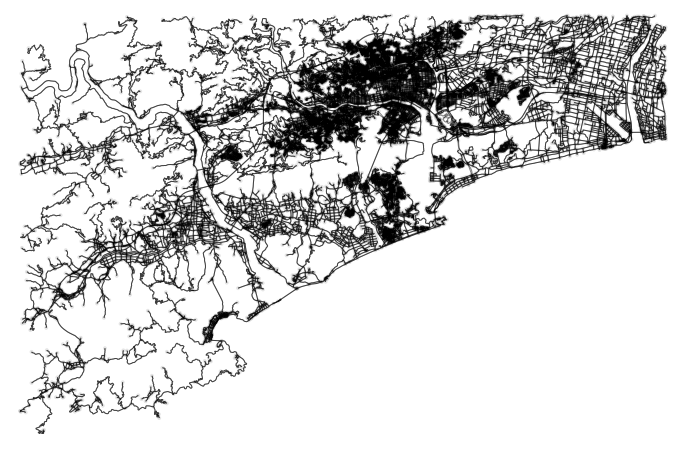

In [29]:
fig = e.e_plot()

In [30]:
nodes = e.e_get_nodes()
edges = e.e_get_edges()

In [1]:
import rasterio
from rasterio.plot import show

In [2]:
raster = rasterio.open('./max5_wgs84_kochishi.tif')

In [33]:
tsu = []
for row in nodes.iterrows():
    x = row[1].x
    y = row[1].y
    row, col = raster.index(x,y)
    try:
        tsu.append(raster.read(1)[row,col])
    except:
        tsu.append(-99)

In [34]:
for i,v in enumerate(tsu):
    if v == -99.:
        tsu[i]=0

In [35]:
max(tsu)

14.46

In [36]:
nodes['tsu']=tsu

In [42]:
nx.set_node_attributes(e.e_G, values=nodes['tsu'], name="depth")
nc = ox.plot.get_node_colors_by_attr(G=e.e_G, attr='depth', cmap='Blues', start=0, stop=1, na_color='none', equal_size=True)
ncr = ox.plot.get_node_colors_by_attr(G=e.e_G, attr='depth', num_bins=5, cmap='Reds', start=0, stop=1, na_color='none', equal_size=False)

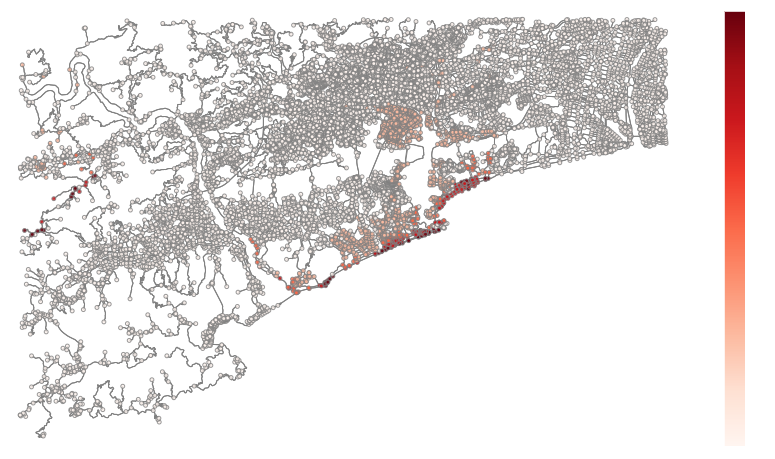

In [43]:
import matplotlib as mpl
import matplotlib.cm as cm

cmap = plt.cm.get_cmap('Reds')
norm=plt.Normalize(vmin=0, vmax=1) # (vmin=nodes['tsu'].min(), vmax=nodes['tsu'].max())
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig,ax = ox.plot_graph(G=e.e_G,ax=None,figsize=(16,8),bgcolor='w',
                       node_color=ncr,node_alpha=0.8,node_edgecolor=None,node_zorder=2,
                         edge_color='grey',show=False,
                         close=False)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical')
fig.savefig('inundation.png')
                    

In [85]:
nodes

,y,x,osmid,highway,ref,geometry,tsu
253768909,33.525490,133.605891,253768909,traffic_signals,NaN,POINT (133.60589 33.52549),0.0
253768914,33.529434,133.628346,253768914,traffic_signals,NaN,POINT (133.62835 33.52943),0.0
253768931,33.536881,133.676919,253768931,NaN,NaN,POINT (133.67692 33.53688),0.0
253768939,33.539952,133.681887,253768939,NaN,NaN,POINT (133.68189 33.53995),0.0
253768943,33.540296,133.691710,253768943,NaN,NaN,POINT (133.69171 33.54030),0.0
...,...,...,...,...,...,...,...
8681358800,33.568821,133.701208,8681358800,NaN,NaN,POINT (133.70121 33.56882),0.0
8721376093,33.527455,133.427255,8721376093,NaN,NaN,POINT (133.42725 33.52746),0.0
8721376104,33.526439,133.427427,8721376104,NaN,NaN,POINT (133.42743 33.52644),0.0
8721376105,33.530705,133.427577,8721376105,NaN,NaN,POINT (133.42758 33.53071),0.0


In [89]:
edges

,osmid,ref,name,highway,maxspeed,oneway,length,geometry,lanes,bridge,access,tunnel,service,junction,u,v,key
0,24226815,14,春野赤岡線,primary,50,False,272.227,"LINESTRING (133.60589 33.52549, 133.60603 33.5...",NaN,NaN,NaN,NaN,NaN,NaN,253768909,304552325,0
1,"[26773944, 27733665, 27733666]",NaN,NaN,tertiary,40,False,409.223,"LINESTRING (133.60589 33.52549, 133.60586 33.5...",2,yes,NaN,NaN,NaN,NaN,253768909,295337060,0
2,27829367,14,春野赤岡線,primary,50,False,46.778,"LINESTRING (133.60589 33.52549, 133.60575 33.5...",2,NaN,NaN,NaN,NaN,NaN,253768909,307976707,0
3,27747486,14,春野赤岡線,primary,50,False,243.939,"LINESTRING (133.62835 33.52943, 133.63071 33.5...",NaN,NaN,NaN,NaN,NaN,NaN,253768914,394709191,0
4,27747486,14,春野赤岡線,primary,50,False,763.259,"LINESTRING (133.62835 33.52943, 133.62625 33.5...",NaN,NaN,NaN,NaN,NaN,NaN,253768914,294071598,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63407,941773038,39,土佐伊野線,primary,NaN,False,126.247,"LINESTRING (133.42758 33.53071, 133.42751 33.5...",NaN,NaN,NaN,NaN,NaN,NaN,8721376105,1541663485,0
63408,140790816,NaN,NaN,residential,NaN,False,41.844,"LINESTRING (133.42784 33.53180, 133.42739 33.5...",NaN,NaN,NaN,NaN,NaN,NaN,8721376111,1541663485,0
63409,140790816,NaN,NaN,residential,NaN,False,34.509,"LINESTRING (133.42784 33.53180, 133.42821 33.5...",NaN,NaN,NaN,NaN,NaN,NaN,8721376111,1541663482,0
63410,140790622,39,土佐伊野線,primary,NaN,False,209.984,"LINESTRING (133.42784 33.53180, 133.42788 33.5...",NaN,NaN,NaN,NaN,NaN,NaN,8721376111,1541663962,0


In [107]:
# edges['risk']=0.5*(nodes.loc[edges['u']]['tsu']+nodes.loc[edges['v']]['tsu'])
risk=[]
for row in edges.iterrows():
    risk.append(0.5*(nodes.loc[row[1].u]['tsu']+nodes.loc[row[1].v]['tsu']))

In [108]:
edges['risk']=risk

In [117]:
p = ox.shortest_path(e.e_G, 253768914, 8721376111, weight='risk')
ox.plot.plot_graph_route(e.e_G, p, route_color='r', route_linewidth=2, route_alpha=0.5, orig_dest_size=100, ax=ax)
fig.savefig('route.png')